# Audio De-Noising with AutoEncoder

In this project, a model utilizing a Convolutional AutoEncoder is developed for the task of denoising short speech segments.

In [1]:
# Dependencies:
import numpy as np
import os
from os import walk
import soundfile
import librosa
import librosa.display
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

# Embed audio files in the notebook:
import IPython.display as ipd

## Data Exploration

The Audio MNIST dataset used here is a collection of recordings of people speaking digits from 0 to nine in the english language. There are 60 total speakers of either gender, with 500 sound samples corresponding to each, making for a total of 30000 samples in the dataset.

A function can be defined to obtain the filepath for each audio file in the Kaggle dataset:

In [2]:
def get_filepaths(directory = "../input/audio-mnist/data"):
    '''
    Generates a list of the paths to all audio files in the dataset.
    '''
    filepaths = []
    
    # Append list with the path to each file:
    for root, dirs, files in os.walk("../input/audio-mnist/data", topdown=False):
        for name in files:
            filepaths.append(os.path.join(root, name))
    
    # The last file is a .txt that should stay out of this list.
    if directory == "../input/audio-mnist/data":
        filepaths = filepaths[:-1]
    
    return filepaths

Calling the function the total number of samples available can be obtained:

In [3]:
filepaths = get_filepaths()

print(len(filepaths), 'audio files in the dataset.')

30000 audio files in the dataset.


The first sample in the dataset can be loaded as an example. The duration is under a second long. The majority of files in the dataset are similarly short recordings.

*(In absence of the dataset, the first audio file is included in the "audio_files" directory as "clean_example.wav".)*

In [4]:
# Load the first file in the dataset:
data, sample_rate = librosa.load(filepaths[0], sr = None)
print('Duration:', len(data)/sample_rate, 's')

# Embed for playback:
ipd.Audio(filepaths[0])

Duration: 0.8291041666666666 s


For the task ahead, the features to be used as input for the denoising model will be the spectrograms for each audio sample. The reasons for choosing spectrograms are:

* Spectral representations of time series can better convey information about the content of the signal than a 1-dimensional waveform.
* Although other features are popular in deep learning for representing audio signals, such as MFCCs, the standard spectrogram can be more efficiently reconstructed back to a waveform, which is crucial if one needs to check the quality of the resulting audio signal, as is the case with a denoising application.

By using spectrograms, the Griffin Lim algorithm can be used to revert the signal back to its time-domain form while maintaining its phase information, and thus constituting a coherrent audio segment. The following code demonstrates going from waveform to spectrogram, and back to waveform:

/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


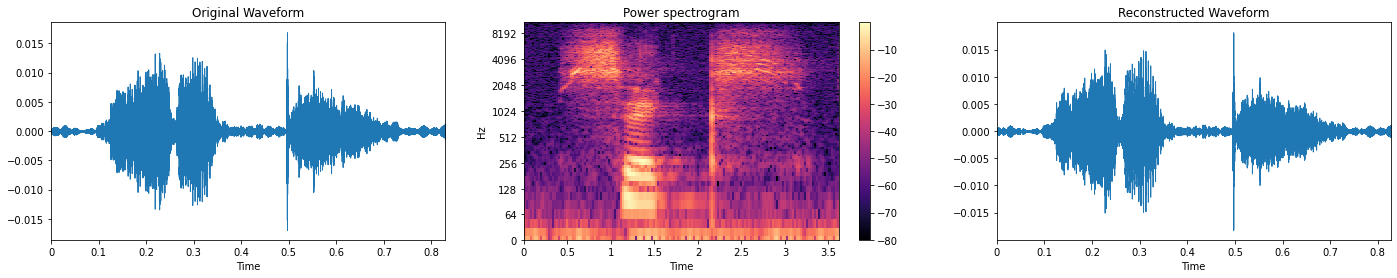

In [5]:
# Calculate STFT to construct spectrogram:
S = np.abs(librosa.stft(data, n_fft = 1024))
# Reconstruct the original waveform from the spectrogram:
data_inv = librosa.griffinlim(S)

# Prepare plot:
fig, ax = plt.subplots(ncols=3, figsize = (24,4))
# Plot original waveform:
librosa.display.waveplot(data, sample_rate, ax = ax[0])
ax[0].set_title('Original Waveform')
# Plot power spectrogram:
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Power spectrogram')
fig.colorbar(img, ax=ax[1])
# Plot reconstructed waveform
librosa.display.waveplot(data_inv, sample_rate, ax = ax[2])
ax[2].set_title('Reconstructed Waveform')

plt.show()

The Griffin Lim algorithm proves to be capable of reconstructing the waveform with minimal alteration compared to the original form. The reconstructed audio for the first sample in the dataset can be played below:

*("griffinlim_example.wav" in the "audio_files" directory)*

In [6]:
# Write the reconstructed audio into a .wav file:
soundfile.write('griffinlim_example.wav', data_inv, sample_rate)
# Embed for playback:
ipd.Audio('./griffinlim_example.wav')

## Adding Noise

For a denoising application, the clean data will not suffice. It is necessary to create noisy counterparts for each audio sample so that the model can be trained to remove that noise and reconstruct a signal according to the clean target. The code below shows the method followed to add random white noise to a base signal:

In [7]:
# Calculate an RMS for the noise relative to the data:
RMS=np.sqrt(np.mean(np.abs(data**2)))
# Generate white noise:
noise=np.random.normal(0, RMS, data.shape[0])
# Add noise to original data at a reasonable level:
data_noisy = data+noise

*(The first audio sample in the dataset with added noise can be found as "noisy_example.wav" in the "audio_files" directory.)*

In [8]:
# Write the noisy audio into a .wav file:
soundfile.write('noisy_example.wav', data_noisy, sample_rate)
# Embed for playback:
ipd.Audio('./noisy_example.wav')

Looking into the spectrogram representations of the clean and the noisy signals, it can be seen how the added noise makes it hard to distinguish the features of the original. It is therefore not a trivial task to reconstruct a clean spectrogram given the presence of such noise levels.

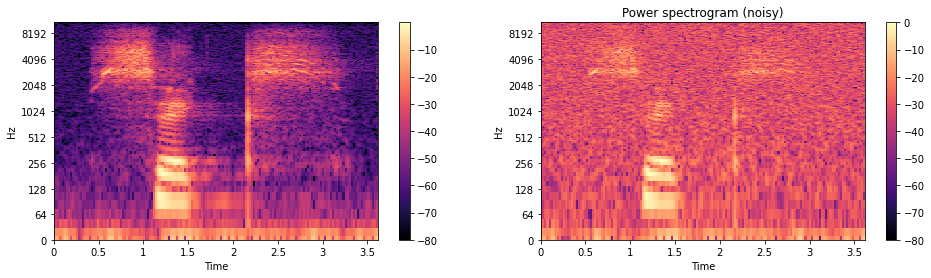

In [9]:
# Calculate STFT to construct spectrogram:
S_noisy = np.abs(librosa.stft(data_noisy, n_fft=1024))

# Prepare plot:
fig, ax = plt.subplots(ncols=2, figsize = (16,4))
# Clean power spectrogram:
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[0])
ax[1].set_title('Power spectrogram (clean)')
fig.colorbar(img, ax=ax[0])
# Noisy power spectrogram
img = librosa.display.specshow(librosa.amplitude_to_db(S_noisy, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Power spectrogram (noisy)')
fig.colorbar(img, ax=ax[1])

plt.show()

## Feature Extraction

The denoising model will require spectrograms corresponding to the clean and the noisy version of each audio sample. In particular, for the training process, the noisy examples are going to be the inputs, and the clean counterparts will be the target that the model should learn to reconstruct. The following function will generate tensors containing the clean and noisy spectrograms to be used.

Consistency in size is required when using a 2D convolutional neural network such as the autoencoder in this project, so all audio files are first padded or cut to have the same duration of 1 second. A spectrogram is calculated for the original clean file, and a noisy spectrogram is calculated for the file with added white noise. 

In [10]:
def get_spectrogram_features(filepaths, noise_gain = 1, sample_rate = 22050, duration_s = 1):
    '''
    Function to generate features for audio de-noising:
    - Reads from paths to audio files specified in "filepaths" list. 
    - Sets to a fixed length.
    - Generates spectrogram.
    - Adds noise and generates corresponding spectrogram.
    - Outputs clean and noisy spectrogram features.
    '''
    X_clean = []
    X_noisy = []
    
    # Get duration in samples:
    duration = int(sample_rate * duration_s)
    
    for filepath in filepaths:
        
        # Read from audio file:
        data, _ = librosa.load(filepath, sr = sample_rate)
        
        # Pad/Cut to appropriate length:
        if len(data) < sample_rate:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = np.pad(data, (offset, duration-len(data)-offset), "constant")
        
        elif len(data) > sample_rate:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = data[offset:len(data)-max_offset+offset]
        
        else:
            offset = 0
   
        # Clean spectrogram:
        S = np.abs(librosa.stft(data, n_fft=2048))[:-1,:] # Hacky fix to keep the size reconstructable
        # Clean feature array:
        X_clean.append(S)
        
        # Generate noise at appropriate level:
        RMS=np.sqrt(np.mean(np.abs(data**2)))
        noise=np.random.normal(0, RMS, data.shape[0])
        # Create noisy waveform:
        data_noisy = data+noise
        # Noisy spectrogram:
        S_noisy = np.abs(librosa.stft(data_noisy, n_fft=2048))[:-1,:] # Hacky fix to keep the size reconstructable
        # Noisy feature array:
        X_noisy.append(S_noisy)
    
    # Convert lists to numpy ndarrays:
    X_clean = np.array(X_clean)
    X_clean = np.expand_dims(X_clean, -1)

    # Expand dimensions to be used as input for the model:
    X_noisy = np.array(X_noisy)
    X_noisy = np.expand_dims(X_noisy, -1)
       
    print('Shape of clean feature tensor:', X_clean.shape)
    print('Shape of noisy feature tensor:', X_noisy.shape)
    
    return X_clean, X_noisy

Due to constraints in storage space and memory, only 500 samples (corresponding to a single speaker) will be used for the training now. Compromises can be made regarding file size by reducing the sample rate or number of fft bins in the spectrogram. However, after some experimentation, it was found that having a good frequency resolution was important in reconstructing good quality audio files. The sample rate can be as low as 22050 Hz. 

In [11]:
# Set sample rate:
sample_rate = 22050
# Get spectrogram features:
X_clean, X_noisy = get_spectrogram_features(filepaths[:500], sample_rate = sample_rate)
# Define input shape for the model:
spec_shape = (X_clean.shape[1], X_clean.shape[2])

Shape of clean feature tensor: (500, 1024, 44, 1)
Shape of noisy feature tensor: (500, 1024, 44, 1)


The tensors containing the clean and noisy spectrograms can be stored as numpy arrays:

In [12]:
# Store spectrogram arrays:
np.save('STFT_Clean.npy', X_clean)
np.save('STFT_Noisy.npy', X_noisy)

In most deep learning models (including this one), it is useful to normalize all data within a specific range of values. A normalizer class can be defined here, which will transform the data so that all values are within the 0 to 1 range. The normalizer is fit on the noisy data, as it is expected to have the highest max values, and the clean data is normalized using the same fit.

In [13]:
class ZeroOneNorm():
    '''
    Normalizes arrays relative to a target array.
    '''
    def __init__(self):
        self.data_to_fit = []
        self.data_to_transform = []
    # Fit to a specific array:
    def fit(self, data_to_fit):
        self.fitting_constant = np.max(np.abs(data_to_fit))
    # Normalize according to fit:
    def normalize(self, data_to_transform):
        normalized_data = data_to_transform / self.fitting_constant
        return normalized_data
    # De-normalize:
    def denormalize(self, data_to_transform):
        denormalized_data = data_to_transform * self.fitting_constant
        return denormalized_data

In [42]:
# Fit normalizer to noisy data:
N = ZeroOneNorm()
N.fit(X_noisy)
# Normalize all data:
X_clean_n = N.normalize(X_clean)
X_noisy_n = N.normalize(X_noisy)

## AutoEncoder

Now that the input and target tensors are ready, it is time to define the model that will be trained to perform the denoising. 

After some experimentation, it was found that a relatively simple architecture of a 2D Convolutional Autoencoder will perform this task best. The model consists of 2 convolution layers and a max pooling layer in the encoder stage, and 2 deconvolutions plus an up-sampling layer in the decoder stage, so that the output retains the same dimensions as the input.

In [43]:
# Convolutional Autoencoder:

# Input layer:
encoder_input = keras.Input(shape=(spec_shape[0], spec_shape[1], 1), name = 'encoder_in')
# Encoder stage:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv_1')(encoder_input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'conv_2')(x)
encoder_output = layers.MaxPooling2D((2, 2), padding='same', name = 'maxpool')(x)
# Decoder stage:
decoder_input = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'decoder_in')(encoder_output)
x = layers.UpSampling2D((2, 2), name = 'upsample')(decoder_input)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'deconv_2')(x)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same',  name = 'deconv_1')(x)
# Autoencoder:
autoencoder = keras.Model(encoder_input, decoder_output, name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_in (InputLayer)      [(None, 1024, 44, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 1024, 44, 32)      320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 1024, 44, 32)      9248      
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 512, 22, 32)       0         
_________________________________________________________________
decoder_in (Conv2D)          (None, 512, 22, 32)       9248      
_________________________________________________________________
upsample (UpSampling2D)      (None, 1024, 44, 32)      0         
_________________________________________________________________
deconv_2 (Conv2D)            (None, 1024, 44, 32)      

For better training, a train/validation split can be performed on the data. A reminder: features (x) in this case are the noisy spectrograms, and targets (y) are the clean ones.

In [44]:
# Perform train-test split on data - features are the noisy spectrograms, labels are the clean spectrograms:
x_train, x_test, y_train, y_test = train_test_split(X_noisy_n, X_clean_n, test_size = 0.2)

The model can now be compiled and trained. Some callbacks such as early stopping and reduction of the learning rate at plateaus can ensure more training efficiency. The loss function to be used is binary crossentropy, which was found to be the most suitable for this task. Worth noting is that using such a loss function, and the sigmoid activation in the output layer of the model, requires data to be normalized to ensure stability.

In [45]:
# Training callbacks:
my_callbacks = [keras.callbacks.EarlyStopping(patience=5), 
                keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=3),
               ]
# Optimizer, learning rate:
opt = keras.optimizers.Adam(learning_rate=0.001)
# Compile Autoencoder w/ optimizer and binary crossentropy loss:
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

# Train autoencoder:
history = autoencoder.fit(x_train, y_train,
                epochs=25,
                shuffle=True,
                validation_data=(x_test, y_test),
                verbose = 1,
                callbacks = my_callbacks
                )

Epoch 1/25
13/13 [==============================] - 1s 80ms/step - loss: 0.6595 - val_loss: 0.2950
Epoch 2/25
13/13 [==============================] - 1s 67ms/step - loss: 0.1418 - val_loss: 0.0244
Epoch 3/25
13/13 [==============================] - 1s 67ms/step - loss: 0.0277 - val_loss: 0.0350
Epoch 4/25
13/13 [==============================] - 1s 67ms/step - loss: 0.0319 - val_loss: 0.0250
Epoch 5/25
13/13 [==============================] - 1s 67ms/step - loss: 0.0210 - val_loss: 0.0143
Epoch 6/25
13/13 [==============================] - 1s 67ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 7/25
13/13 [==============================] - 1s 67ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 8/25
13/13 [==============================] - 1s 69ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 9/25
13/13 [==============================] - 1s 67ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 10/25
13/13 [==============================] - 1s 66ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 11/

## Results

The training appears successfull. Plotting the history of the losses it is evident that the model quickly converged to a minimum loss and stayed there, indicating that this is as low as this specific architecture can go given this dataset.

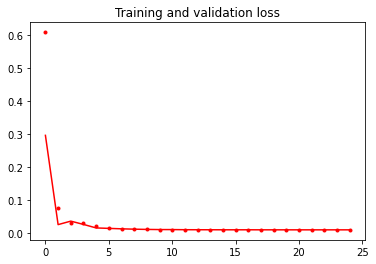

In [46]:
def plot_training(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
  
    plt.plot(epochs, train_loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
    
plot_training(history)

To check what this low loss corresponds to with regards to the purpose of this application, the input and output spectrograms for the autoencoder can be displayed. It is also most useful to compare the denoised output spectrogram to the original clean target.

In [47]:
def spec_plot(spectrogram, ax_index, title):
    spectrogram = spectrogram.reshape((1024, 44))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref = np.max), ax = ax[ax_index])
    ax[ax_index].set_title(title)

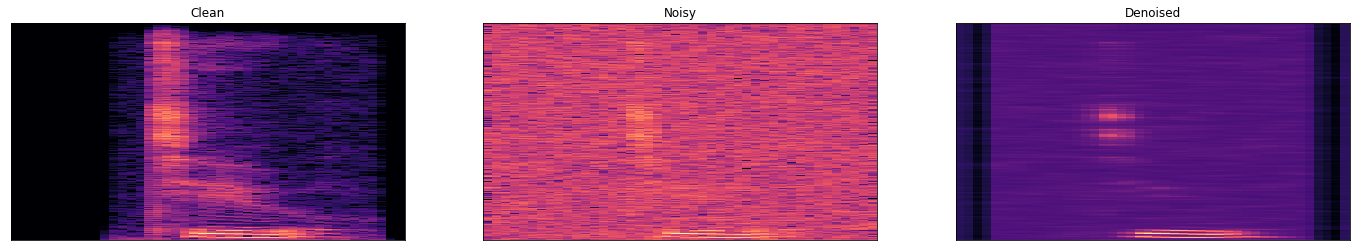

In [48]:
the# Index of sample to check:
index = 11

# Prepare plot:
fig, ax = plt.subplots(ncols=3, figsize = (24,4))
# Spectrogram of original clean audio:
clean = y_test[index]
spec_plot(clean, 0, 'Clean')
# Spectrogram of noisy audio:
noisy = x_test[index]
spec_plot(noisy, 1, 'Noisy')
# Spectrogram of denoised audio:
denoised = autoencoder.predict(np.reshape(noisy, (1, noisy.shape[0], noisy.shape[1], 1)))
spec_plot(denoised, 2, 'Denoised')

plt.show()

From the images above it can be seen that the noise has been greatly reduced. However, there also seems to be some information lost between the original and the reconstructed spectrograms. In order to understand how severe this is, the waveforms need to be calculated and listened to.

In [49]:
# Transform spectrograms into waveforms and store them as .wav files:
# Clean
spec = N.denormalize(clean.reshape(spec_shape))
spec_inv = librosa.griffinlim(spec)
soundfile.write('clean.wav', spec_inv, sample_rate)
# Noisy
spec = N.denormalize(noisy.reshape(spec_shape))
spec_inv = librosa.griffinlim(spec)
soundfile.write('noisy.wav', spec_inv, sample_rate)
# Denoised
spec = N.denormalize(denoised.reshape(spec_shape))
spec_inv = librosa.griffinlim(spec)
soundfile.write('denoised.wav', spec_inv, sample_rate)

*The corresponding audiofiles are stored as "clean.wav", "noisy.wav" and "denoised.wav" in the "audio_files" directory.*

In [50]:
# Embedded playback:
ipd.Audio('clean.wav')

In [51]:
# Embedded playback:
ipd.Audio('noisy.wav')

In [52]:
# Embedded playback:
ipd.Audio('denoised.wav')

So it can be heard that the denoised audio is decipherable and the noise is greatly reduced. Compared to the original, however, there is audible difference in the timbre.

### Denoising new data

The denoiser proved to work on data it was already trained on. But the most important thing is to be able to denoise new audio data. For this purpose, other audio samples from the same dataset can be used, this time belonging to different speakers not included in the training data. 

The new audio will also have to go through a preprocessing stage in order to extract the spectrogram features, its clean and noisy counterparts:

In [53]:
def preprocess(filepath, sample_rate = 22050, duration_s = 1):
        '''
        Pre-process single audio file for denoising.
        '''
        data, _ = librosa.load(filepath, sr = sample_rate)
        
        duration = duration_s * sample_rate
        
        # Pad/Cut to appropriate length:
        if len(data) < sample_rate:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = np.pad(data, (offset, duration-len(data)-offset), "constant")
        
        elif len(data) > sample_rate:
            max_offset = np.abs(len(data) - duration)
            offset = np.random.randint(max_offset)
            data = data[offset:len(data)-max_offset+offset]
        
        else:
            offset = 0
   
        # Clean spectrogram:
        S = np.abs(librosa.stft(data, n_fft=2048))[:-1,:] # Hacky fix to keep the size reconstructable
        # Clean feature array:
        X_clean = np.reshape(S, (1, S.shape[0], S.shape[1], 1))
        
        # Generate noise at appropriate level:
        RMS=np.sqrt(np.mean(np.abs(data**2)))
        noise=np.random.normal(0, RMS, data.shape[0])
        # Create noisy waveform:
        data_noisy = data+noise
        # Noisy spectrogram:
        S_noisy = np.abs(librosa.stft(data_noisy, n_fft=2048))[:-1,:] # Hacky fix to keep the size reconstructable
        # Noisy feature array:
        X_noisy = np.reshape(S_noisy, (1, S.shape[0], S.shape[1], 1))
        
        return X_clean, X_noisy

The spectrograms should also be normalized with reference to the training parameters, before being used as input to the AutoEncoder.

In [73]:
# Choose new audio file to be denoised:
test_clean, test_noisy = preprocess(filepaths[669])

# Normalize spectrogram:
test_noisy_n = N.normalize(test_noisy)

# Denoise by implementing AutoEncoder:
test_denoised = autoencoder.predict(test_noisy_n)

Now to see how the model performs on unknown data:

From the spectrograms it appears that the noise has been significantly reduced, albeit with the loss of some high frequency components of the original.

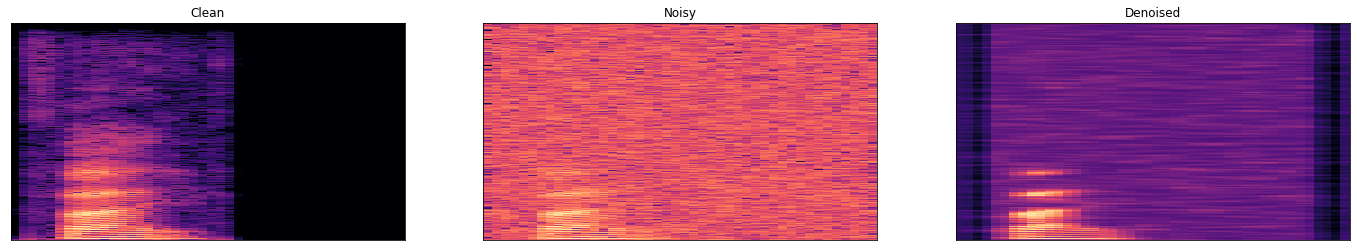

In [74]:
# Prepare plot:
fig, ax = plt.subplots(ncols=3, figsize = (24,4))
# Spectrogram of original clean audio:
spec_plot(test_clean, 0, 'Clean')
# Spectrogram of noisy audio:
spec_plot(test_noisy, 1, 'Noisy')
# Spectrogram of denoised audio:
spec_plot(test_denoised, 2, 'Denoised')

plt.show()

As before, the objective here is to have a clean audio file. By reconstructing the waveforms, it can be heard that while there is an audible alteration compared to the original clean sample, the denoiser has successfully removed the noise and the result remains perfectly decipherable.

In [75]:
# Transform spectrograms into waveforms and store them as .wav files:
# Clean
spec = test_clean.reshape(spec_shape)
spec_inv = librosa.griffinlim(spec)
soundfile.write('test_clean.wav', spec_inv, sample_rate)
# Noisy
spec = test_noisy.reshape(spec_shape)
spec_inv = librosa.griffinlim(spec)
soundfile.write('test_noisy.wav', spec_inv, sample_rate)
# Denoised
spec = N.denormalize(test_denoised.reshape(spec_shape))
spec_inv = librosa.griffinlim(spec)
soundfile.write('test_denoised.wav', spec_inv, sample_rate)

In [76]:
# Embedded playback:
ipd.Audio('test_clean.wav')

In [77]:
# Embedded playback:
ipd.Audio('test_noisy.wav')

In [78]:
# Embedded playback:
ipd.Audio('test_denoised.wav')

The trained model can be saved for future deployment on similar audio samples:

In [95]:
autoencoder.save('audio_denoise_AE.h5')